# Deep Learning with PyTorch : Build a Generative Adversarial Network

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Configurations

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
noise_dim = 64

# Optimizer parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 20

# Load MNIST Dataset

In [51]:
from torchvision import datasets, transforms

In [52]:

train_augs = transforms.Compose([
    transforms.RandomRotation((-20,20)),
    transforms.ToTensor()   # (h,w,c) -> (c,w,h)
])

In [53]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

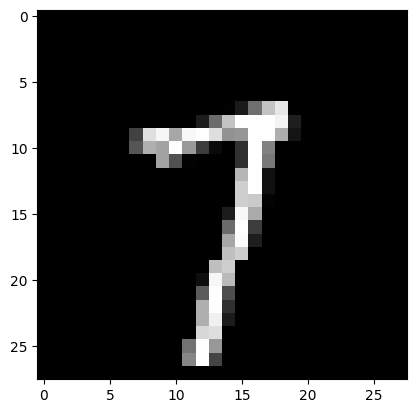

In [54]:
image, label = trainset[42]

plt.imshow(image.squeeze(), cmap='gray')

In [ ]:
len(trainset)

# Load Dataset Into Batches

In [56]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [57]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [58]:
dataiter = iter(trainloader)

images, _ = next(dataiter)

images.shape

torch.Size([128, 1, 28, 28])

In [59]:
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    """Displays a grid of images from a tensor.

    Args:
        tensor_images: A tensor of images with shape (batch_size, channels, height, width).
        num_images: The number of images to display.
        size: The size of each image (channels, height, width).

    Returns:
        None
    """
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

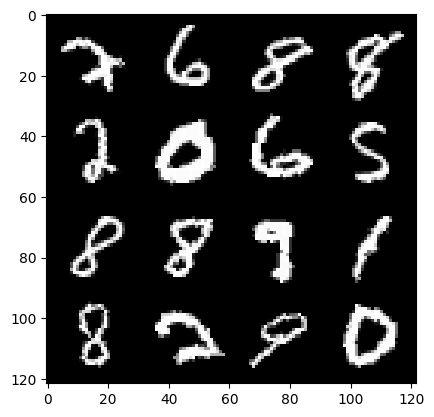

In [60]:
show_tensor_images(images, 16)

# Create Discriminator Network

In [61]:
# In case torch summary is not installed

!pip install torchsummary

In [62]:
from torch import nn
from torchsummary import summary

In [63]:
def get_disc_block(in_chan, out_chan, kernel_size, stride):
  """Creates a single block for the discriminator network.
  Args:
      in_channels: Number of input channels.
      out_channels: Number of output channels.
      kernel_size: Size of the convolutional kernel.
      stride: Stride of the convolution.
  Returns:
      nn.Sequential: A sequential block with Conv2d, BatchNorm2d, and LeakyReLU layers.
  """
  return nn.Sequential(
      nn.Conv2d(in_chan, out_chan, kernel_size, stride),
      nn.BatchNorm2d(out_chan),
      nn.LeakyReLU(0.2)
  )


In [64]:
class Discriminator(nn.Module):
  """Defines the discriminator network architecture."""

  def __init__(self):
     super(Discriminator, self).__init__()

     self.block_1 = get_disc_block(1, 16, (3,3), 2)
     self.block_2 = get_disc_block(16, 32, (5,5), 2)
     self.block_3 = get_disc_block(32, 64, (5,5), 2)
     self.flatten = nn.Flatten()
     self.linear = nn.Linear(in_features=64, out_features=1)

  def forward(self, images):
    """
    Forward pass of the discriminator network.
    Args:
        x: Input tensor of images.
    Returns:
        torch.Tensor: Output logits of the discriminator.
    """
    x = self.block_1(images)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.flatten(x)
    x = self.linear(x)

    return x

In [65]:
disc = Discriminator().to(device)


summary(disc, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [66]:
def get_gen_block(in_chan, out_chan, kernel_size, stride, final_block = False):
  """Creates a single block for the generator network.
  Args:
      in_channels: Number of input channels.
      out_channels: Number of output channels.
      kernel_size: Size of the convolutional kernel.
      stride: Stride of the convolution.
      final_block: Whether this is the final block in the network.
  Returns:
      nn.Sequential: A sequential block with ConvTranspose2d, BatchNorm2d, and ReLU/Tanh layers.
  """
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_chan, out_chan, kernel_size, stride),
        nn.Tanh()
    )

  return nn.Sequential(
      nn.ConvTranspose2d(in_chan, out_chan, kernel_size, stride),
      nn.BatchNorm2d(out_chan),
      nn.ReLU()
  )

In [67]:
class Generator(nn.Module):
  """Defines the generator network architecture."""

  def __init__(self, noise_dim):
    super(Generator,self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block=True)

  def forward(self, noise):
    """
    Forward pass of the generator network.
    Args:
        x: Input noise tensor of shape (batch_size, noise_dim, 1, 1).
    Returns:
        torch.Tensor: Generated images tensor.
    """
    x = self.block_1(noise)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)

    return x


In [68]:
gen = Generator(noise_dim).to(device)

summary(gen, input_size = (noise_dim, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [69]:
def weights_init(m):
    """Initializes weights of a module with normal distribution.

    Args:
        m: The module to initialize weights for.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0.0)

In [70]:
disc = disc.apply(weights_init)
gen = gen.apply(weights_init)

# Create Loss Function and Load Optimizer

In [71]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(disc_pred, torch.ones_like(disc_pred))
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(disc_pred, torch.zeros_like(disc_pred))
  return loss

In [72]:
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | disc_loss : 0.6835213733126105 | gen_loss : 0.6835213733126105


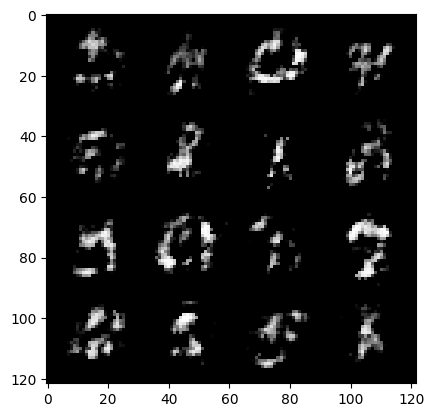

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | disc_loss : 0.6719854420690394 | gen_loss : 0.6719854420690394


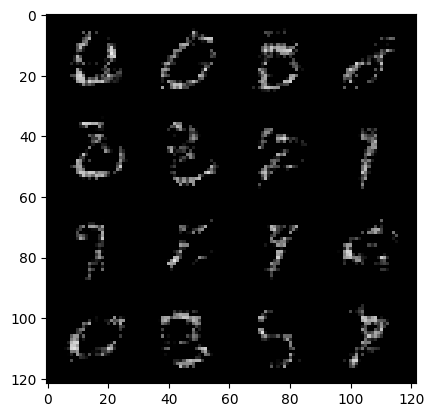

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | disc_loss : 0.6182279914681083 | gen_loss : 0.6182279914681083


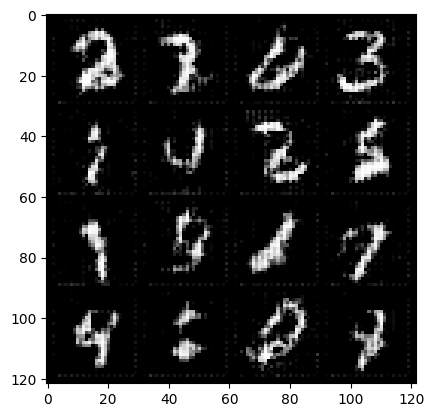

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | disc_loss : 0.5911357374841979 | gen_loss : 0.5911357374841979


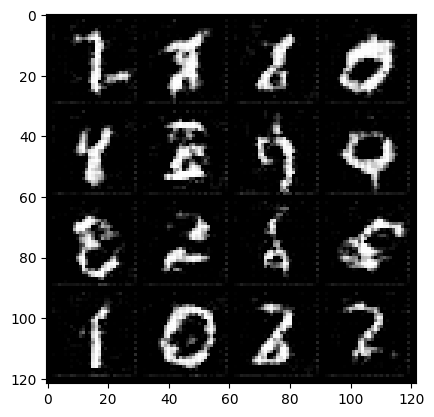

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | disc_loss : 0.580743840762547 | gen_loss : 0.580743840762547


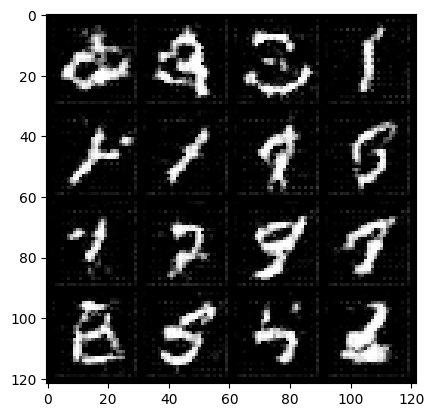

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | disc_loss : 0.5855589383192408 | gen_loss : 0.5855589383192408


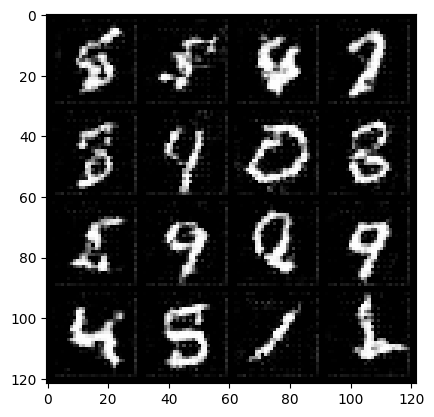

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | disc_loss : 0.5999255299822354 | gen_loss : 0.5999255299822354


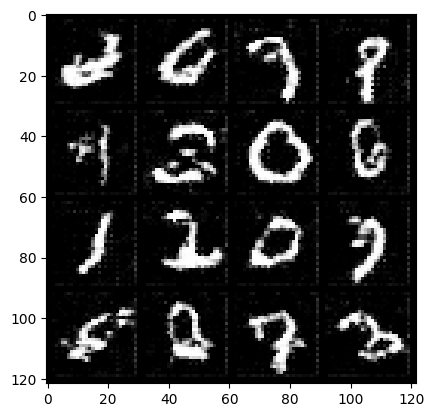

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | disc_loss : 0.6114161938492423 | gen_loss : 0.6114161938492423


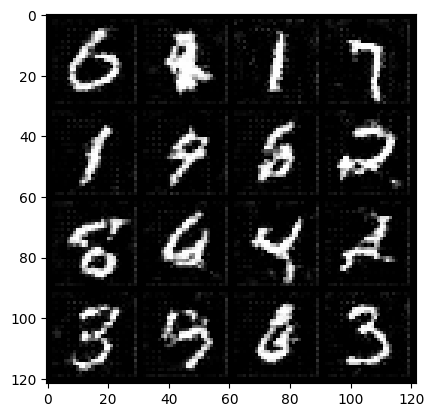

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | disc_loss : 0.6179937955413037 | gen_loss : 0.6179937955413037


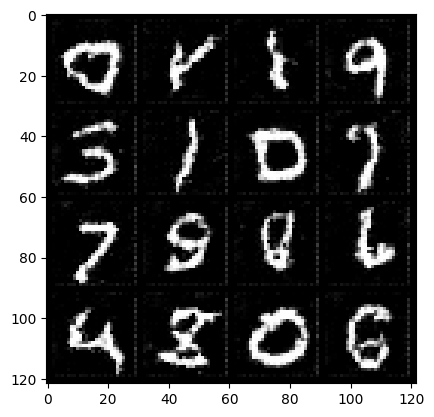

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | disc_loss : 0.6102857461361997 | gen_loss : 0.6102857461361997


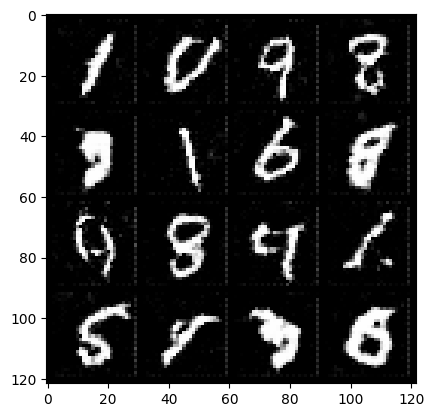

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | disc_loss : 0.6096280171418749 | gen_loss : 0.6096280171418749


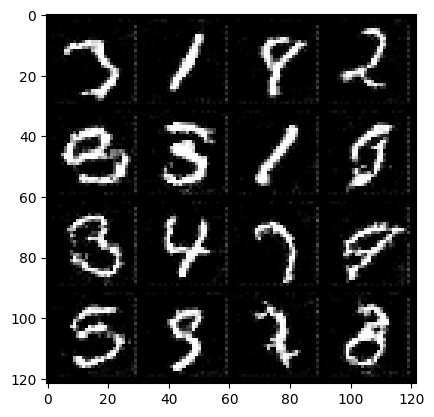

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | disc_loss : 0.6187500506321758 | gen_loss : 0.6187500506321758


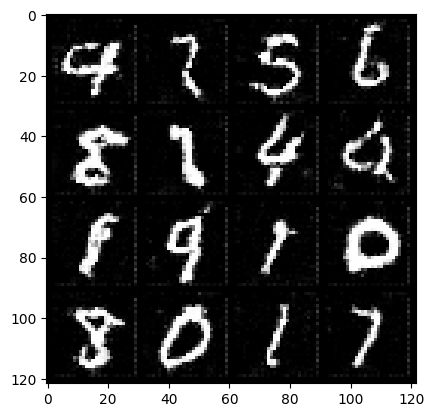

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | disc_loss : 0.6279435034499747 | gen_loss : 0.6279435034499747


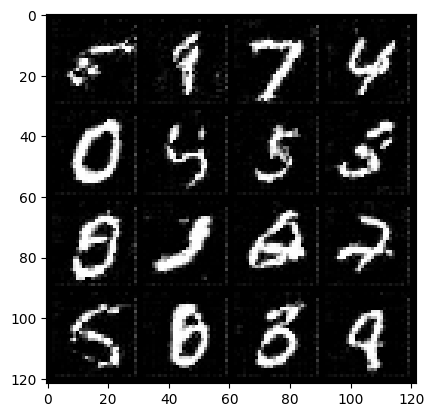

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | disc_loss : 0.6339779867292213 | gen_loss : 0.6339779867292213


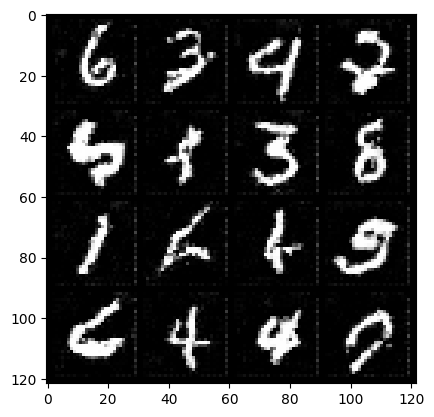

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | disc_loss : 0.6372080641006356 | gen_loss : 0.6372080641006356


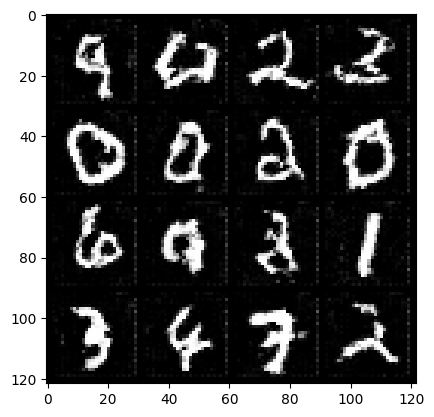

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | disc_loss : 0.6412669598166623 | gen_loss : 0.6412669598166623


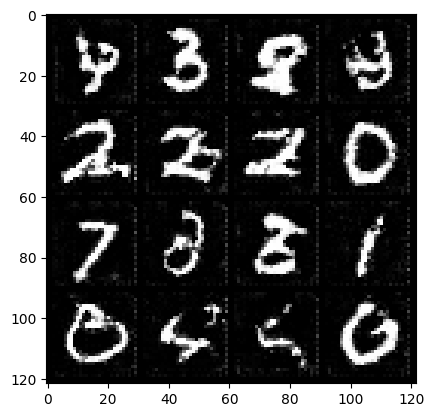

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | disc_loss : 0.642256006503156 | gen_loss : 0.642256006503156


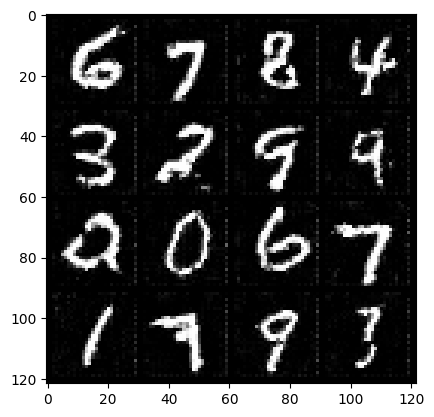

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | disc_loss : 0.6458482390273609 | gen_loss : 0.6458482390273609


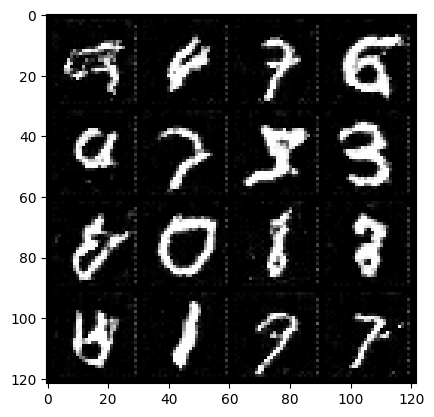

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | disc_loss : 0.644197808908247 | gen_loss : 0.644197808908247


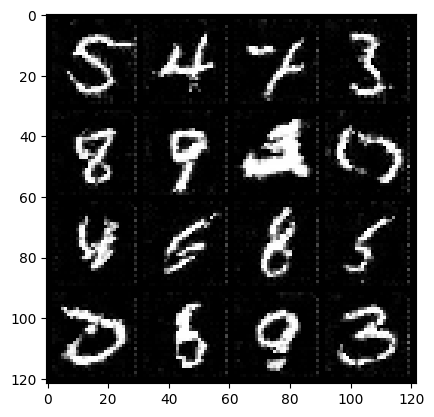

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | disc_loss : 0.6466648998036821 | gen_loss : 0.6466648998036821


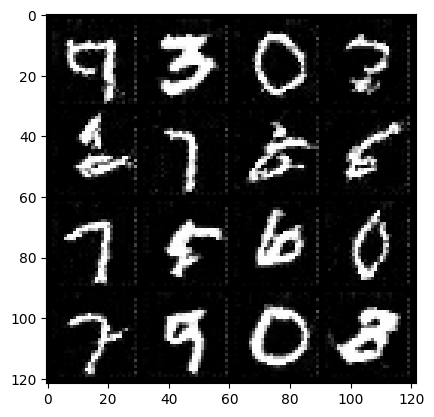

In [74]:
for i in range(epochs):

  disc_loss_total = 0.0
  gen_loss_total = 0.0

  for real_imgs, _ in tqdm(trainloader):
    real_imgs = real_imgs.to(device)
    noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

    # Train Discriminator
    disc_opt.zero_grad()

    # Generate fake images and get discriminator predictions
    fake = gen(noise)
    fake_pred = disc(fake)
    disc_fake_loss = fake_loss(fake_pred)

    # Get discriminator predictions for real images
    real_pred = disc(real_imgs)
    disc_real_loss = real_loss(real_pred)

    # Combine losses and backprop for discriminator

    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    disc_loss_total += disc_loss.item()
    disc_loss.backward()
    disc_opt.step()

    # Train Generator
    gen_opt.zero_grad()


    # Generate fake images and get discriminator predictions
    noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
    fake = gen(noise)
    fake_pred = disc(fake)

    # Calculate generator loss based on discriminator predictions

    gen_loss = real_loss(fake_pred)

    gen_loss_total += gen_loss.item()

    gen_loss.backward()
    gen_opt.step()

  # Calculate average losses
  avg_d_loss = disc_loss_total / len(trainloader)
  avg_g_loss = disc_loss_total / len(trainloader)

  # Print epoch summary
  print(f"Epoch : {i+1} | disc_loss : {avg_d_loss} | gen_loss : {avg_g_loss}")

  show_tensor_images(fake)

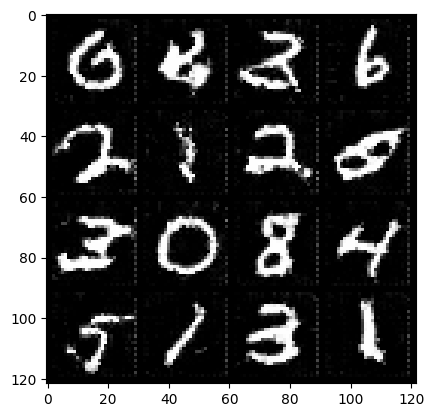

In [77]:
# Generate images after training

noise = torch.randn(batch_size, noise_dim, 1, 1, device = device)
generated_image = gen(noise)

# Plot generated images
show_tensor_images(generated_image)